# Image Classification Roundworms
## Daniel Marranzini

In this notebook we will first build a simple model to detect if a group of roundworms is mostly dead or mostly alive. After testing that model on our dataset we will then apply a different technique using edge detection and compare our results to determine the better approach to building an image classifier without the help of neural nets.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [70]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)
                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames


# The images are in a folder named 'AssignmentData/training'
training_folder_name =  '/content/gdrive/My Drive/AssignmentData/training'

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)

Reading data from dead
Reading data from live
70 features
70 labels
2 classes: ['dead', 'live']


In [71]:
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Feature Shape: (70, 361920)
Labels Shape: (70,)


Let's split the data. We have little data to work with, but I still opted to give 30% to our testing data so we would be able to better evaluate the performance of the model.

In [87]:
# split into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30)

print('Training records:',Y_train.size)
print('Test records:',Y_test.size)

Training records: 49
Test records: 21


Here we will train our classification model. First we normalize the pixel values so they are all scaled between 0 and 1 and then we apply SciKit-Learn's Decision Tree algorithm for classification.

In [88]:
# Train the model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

# Convert the training features to floats so they can be scaled
X_train_float = X_train.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', DecisionTreeClassifier()),
                        ])

# Use the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, Y_train)

print('classifier trained!')

Training model...
classifier trained!


Now we will use our model to predict the labels of the test data we set aside earlier and plot a confusion matrix to better visualize the success of our results.

Classifier Metrics:
              precision    recall  f1-score   support

        dead       0.92      0.92      0.92        12
        live       0.89      0.89      0.89         9

    accuracy                           0.90        21
   macro avg       0.90      0.90      0.90        21
weighted avg       0.90      0.90      0.90        21

Accuracy: 90.48%

 Confusion Matrix:


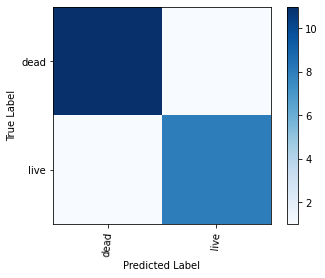

In [89]:
# Evaluate classifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Convert the test features for scaling
X_test_float = X_test.astype('float64')

print('Classifier Metrics:')
predictions = clf.predict(X_test)
print(metrics.classification_report(Y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(Y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Saving the model for future use...

In [90]:
# Save the trained model
import sys
import os
import pickle

print ("Exporting the model")
file_stream = open('roundworm_classifier.pkl', 'wb')
pickle.dump(clf, file_stream)
file_stream.close()

Exporting the model


Now we will create two functions to resize the new images to match the size of the images from the training data and submit the new images to the model and return its predictions.

In [91]:
# Helper function to resize image
def resize_image(src_img, size=(128,128), bg_color="white"): 
    from PIL import Image

    # rescale the image so the longest edge is the right size
    src_img.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new image of the right shape
    new_image = Image.new("L", size)
    
    # Paste the rescaled image onto the new background
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))
  
    # return the resized image
    return new_image

# Function to predict the class of an image
def predict_image(classifier, image_array):
    import numpy as np
    
    # These are the classes our model can predict
    classnames = ['dead', 'live']
    
    # Predict the class of each input image
    predictions = classifier.predict(image_array)
    
    predicted_classes = []
    for prediction in predictions:
        # And append the corresponding class name to the results
        predicted_classes.append(classnames[int(prediction)])
    # Return the predictions
    return predicted_classes

print("Functions created - ready to use model for inference.")

Functions created - ready to use model for inference.


Here we will use the model we saved and our helper functions to predict the classes of our new images and display the results.

Importing the model


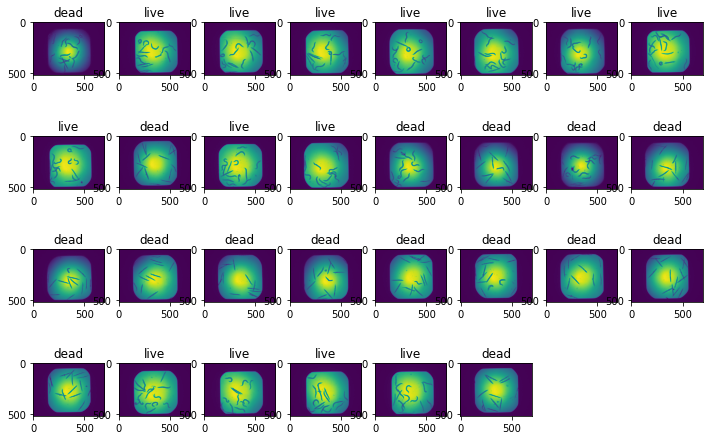

In [92]:
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

# Load the model
print("Importing the model")
file_stream = open('roundworm_classifier.pkl', 'rb')
clf = pickle.load(file_stream)
file_stream.close()

#get the list of test image files
test_folder = '/content/gdrive/My Drive/AssignmentData/testing'
test_image_files = os.listdir(test_folder)

# Empty array on which to store the images
image_arrays = []

size = (696,520)
background_color = "white"

fig = plt.figure(figsize=(12, 8))

# Get the images and show the predicted classes
for file_idx in range(len(test_image_files)):
    img = Image.open(os.path.join(test_folder, test_image_files[file_idx]))
    
    # resize the image so it matches the training set - it  must be the same size as the images on which the model was trained
    resized_img = np.array(resize_image(img, size, background_color))
    
    img_shape = np.array(resized_img).shape
                      
    # Add the image to the array of images
    image_arrays.append(resized_img.ravel())

# Get predictions from the array of image arrays
# Note that the model expects an array of 1 or more images - just like the batches on which it was trained
predictions = predict_image(clf, np.array(image_arrays))

# plot easch image with its corresponding prediction
for idx in range(len(predictions)):
    a=fig.add_subplot(4,8,idx+1)
    img = image_arrays[idx].reshape(img_shape)
    imgplot = plt.imshow(img)
    a.set_title(predictions[idx])


This initial model seems to be performing quite well, only some images were classified as dead when they were mostly alive. Let's see if we can improve it with another strategy using edge detection.

# Part 2 Using Edges

Importing the data once again and creating new features with edge detection this time:

In [46]:
!pip install opencv-python

In [93]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    import cv2
    import math

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                #print(f)
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)
                scale_percent = 50 # percent of original size
                width = int(img.shape[1] * scale_percent / 100)
                height = int(img.shape[0] * scale_percent / 100)
                dim = (width, height)
                # resize image
                resizedG = cv2.resize(img, dim)
                #sobel edge detection of gray level image
                sobelx = cv2.Sobel(resizedG,cv2.CV_64F,1,0,ksize=5)
                sobely = cv2.Sobel(resizedG,cv2.CV_64F,0,1,ksize=5)
                #print(sobelx.type)
                #magniture
                sobel=np.sqrt(np.multiply(sobelx,sobelx)+np.multiply(sobely,sobely))
                vis = np.concatenate((resizedG, sobel), axis=0)
                #with only edge info
                #vis=sobel

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(vis.ravel())
                #features.append(sobel.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames


# The images are in a folder named 'shapes/training'
training_folder_name = '/content/gdrive/My Drive/AssignmentData/training'

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)

Reading data from dead
Reading data from live
70 features
70 labels
2 classes: ['dead', 'live']


Split into train and test:

In [94]:
# split into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.20)

print('Training records:',Y_train.size)
print('Test records:',Y_test.size)

Training records: 56
Test records: 14


Once again we scale our pixel values between 0 and 1 and apply our Decision Tree Classifier to train our model.

In [95]:
# Train the model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

# Convert the training features to floats so they can be scaled
X_train_float = X_train.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', DecisionTreeClassifier()),
                        ])

# Use the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, Y_train)

print('classifier trained!')

Training model...
classifier trained!


Evaluating our model:

Classifier Metrics:
              precision    recall  f1-score   support

        dead       1.00      1.00      1.00         6
        live       1.00      1.00      1.00         8

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14

Accuracy: 100.00%

 Confusion Matrix:


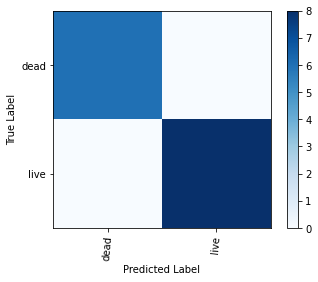

In [96]:
# Evaluate classifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Convert the test features for scaling
X_test_float = X_test.astype('float64')

print('Classifier Metrics:')
predictions = clf.predict(X_test)
print(metrics.classification_report(Y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(Y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

The model here seems to be performing significantly better! The 100% accuracy could be a matter of luck with the train/test split, but the improvement from our last model cannot be denied. Let's save it and expose it to new data to see how it performs.

In [97]:
# Save the trained model
import sys
import os
import pickle

print ("Exporting the model")
file_stream = open('roundworm_classifier_edge.pkl', 'wb')
pickle.dump(clf, file_stream)
file_stream.close()

Exporting the model


Importing our saved model and using the helper functions we defined in part 1 to make predictions on our new testing data and display the results.

Importing the model


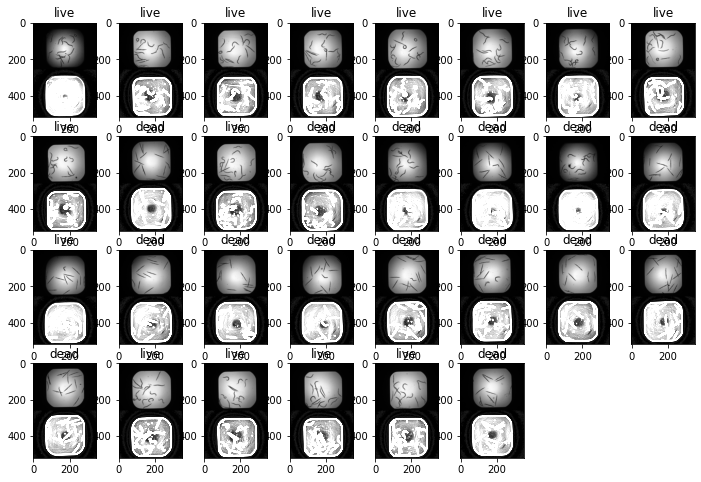

In [99]:
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import cv2
%matplotlib inline

# Load the model
print("Importing the model")
file_stream = open('roundworm_classifier_edge.pkl', 'rb')
clf = pickle.load(file_stream)
file_stream.close()

#get the list of test image files
test_folder = '/content/gdrive/My Drive/AssignmentData/testing'
test_image_files = os.listdir(test_folder)

# Empty array on which to store the images
image_arrays = []

size = (696,520)
background_color = "white"

fig = plt.figure(figsize=(12, 8))

# Get the images and show the predicted classes
for file_idx in range(len(test_image_files)):
    img = Image.open(os.path.join(test_folder, test_image_files[file_idx]))
    
    # resize the image so it matches the training set - it  must be the same size as the images on which the model was trained
    resized_img = np.array(resize_image(img, size, background_color))
    
    img_shape = np.array(resized_img).shape
    scale_percent = 50 # percent of original size
    width = int(resized_img.shape[1] * scale_percent / 100)
    height = int(resized_img.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    resizedG = cv2.resize(resized_img, dim, interpolation = cv2.INTER_AREA)
    #sobel edge detection of gray level image
    #resizedG=cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    #sobel edge detection
    sobelx = cv2.Sobel(resizedG,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(resizedG,cv2.CV_64F,0,1,ksize=5)
    #print(sobelx.type)
    #magniture
    sobel=np.sqrt(np.multiply(sobelx,sobelx)+np.multiply(sobely,sobely))
    vis = np.concatenate((resizedG, sobel), axis=0)
    #just edge image
    #vis=sobel
    vis_shape=np.array(vis).shape
    # The image array is a multidimensional numpy array
    # - flatten it to a single array of pixel values for scikit-learn
    # - and add it to the list of features
    image_arrays.append(vis.ravel())
    # Add the image to the array of images
    #image_arrays.append(resized_img.ravel())

# Get predictions from the array of image arrays
# Note that the model expects an array of 1 or more images - just like the batches on which it was trained
predictions = predict_image(clf, np.array(image_arrays))

# plot easch image with its corresponding prediction
for idx in range(len(predictions)):
    a=fig.add_subplot(4,8,idx+1)
    img = image_arrays[idx].reshape(vis_shape).astype(int)
    imgplot = plt.imshow(img.astype(int),cmap='gray', vmin=0, vmax=255)
    a.set_title(predictions[idx])

There are still some images where the roundworms are mostly alive being classified as dead, but the improvement from our first model is noticeable. It seems edge detection is the way to go! I can't wait to see what type of models we can create with neural nets.